In [1]:
import io
import os
import json
import copy
import lmdb
import random
import numpy as np
from PIL import Image, ImageDraw
from itertools import filterfalse
from maskrcnn_benchmark.structures.segmentation_mask import SegmentationMask

from viz_utils import *

In [2]:
class PhotoData(object):
    def __init__(self, path):
        self.env = lmdb.open(
            path, map_size=2**36, readonly=True, lock=False
        )
        
    def __iter__(self):
        with self.env.begin() as t:
            with t.cursor() as c:
                for key, value in c:
                    yield key, value
        
    def __getitem__(self, index):
        key = str(index).encode('ascii')
        with self.env.begin() as t:
            data = t.get(key)
        if not data:
            return None
        with io.BytesIO(data) as f:
            image = Image.open(f)
            image.load()
            return image
        
    def __len__(self):
        return self.env.stat()['entries']

In [3]:
data = {}
with open('/data/modanet/annotations/modanet2018_instances_train.json') as f :
    data = json.load(f)

In [4]:
del data['categories'][2] # delete boots
del data['categories'][2] # delete footwear
for category in data['categories'] : 
    if category['id'] > 4 :
        category['id'] = category['id'] - 2

In [5]:
# delete all footwear & boots

anno_keep = list(filterfalse(lambda anno : (anno['category_id'] == 3 or anno['category_id'] == 4), data['annotations']))
data['annotations'] = anno_keep
imgids = list(set([anno['image_id'] for anno in data['annotations']]))
imgids_ = set(imgids)
imageinfo_keep = list(filterfalse(lambda imginfo : not (imginfo['id'] in imgids_), data['images']))
data['images'] = imageinfo_keep

In [6]:
# relabel the rest 
for ix, annotation in enumerate(data['annotations']) : 
    category_id = annotation['category_id']
    if category_id > 4 :
        annotation['category_id'] = category_id - 2

In [7]:
photo_data = PhotoData('/data/modanet/photos.lmdb')

In [8]:
random.shuffle(imgids)

In [9]:
numtrain = int(len(imgids)*.95)
trainids = set(imgids[:numtrain])
valids = set(imgids[numtrain:])

In [10]:
data_ = {}
data_['info'] = data['info']
data_['year'] = data['year']
data_['licenses'] = data['licenses']
data_['type'] = data['type']
data_['categories'] = data['categories']
data_['images'] = []
data_['annotations'] = []

In [11]:
traindata = copy.deepcopy(data_)
valdata = copy.deepcopy(data_)

In [12]:
for imgdata in data['images'] :
    if imgdata['id'] in trainids :
        traindata['images'].append(imgdata)
    else :
        valdata['images'].append(imgdata)

In [13]:
for annotation in data['annotations']:
    if annotation['image_id'] in trainids :
        traindata['annotations'].append(annotation)
    else :
        valdata['annotations'].append(annotation)

In [14]:
with open('/data/modanet/annotations/modanet2018_instances_train_latest.json', 'w') as f :
    json.dump(traindata, f)

In [15]:
with open('/data/modanet/annotations/modanet2018_instances_val_latest.json', 'w') as f :
    json.dump(valdata, f)

In [16]:
base_train_dir = '/data/modanet/images/train'
for imageinfo in traindata['images'] : 
    imageid = imageinfo['id']
    filename = imageinfo['file_name']
    img = photo_data[imageid]
    img.save(os.path.join(base_train_dir, filename))

In [17]:
base_val_dir = '/data/modanet/images/val'
for imageinfo in valdata['images'] : 
    imageid = imageinfo['id']
    filename = imageinfo['file_name']
    img = photo_data[imageid]
    img.save(os.path.join(base_val_dir, filename))

### Let's draw a few annotations for an image

In [19]:
import pycocotools.mask as mask_utils

In [4]:
with open('/data/modanet/annotations/modanet2018_instances_train_latest.json') as f :
    train_annotations = json.load(f)
trainids = [ann['id'] for ann in train_annotations['images']]
classnames = ['bag', 'belt', 'outer', 'dress', 'sunglasses', 
              'pants', 'top', 'shorts', 'skirt', 'headwear', 'scarf & tie']

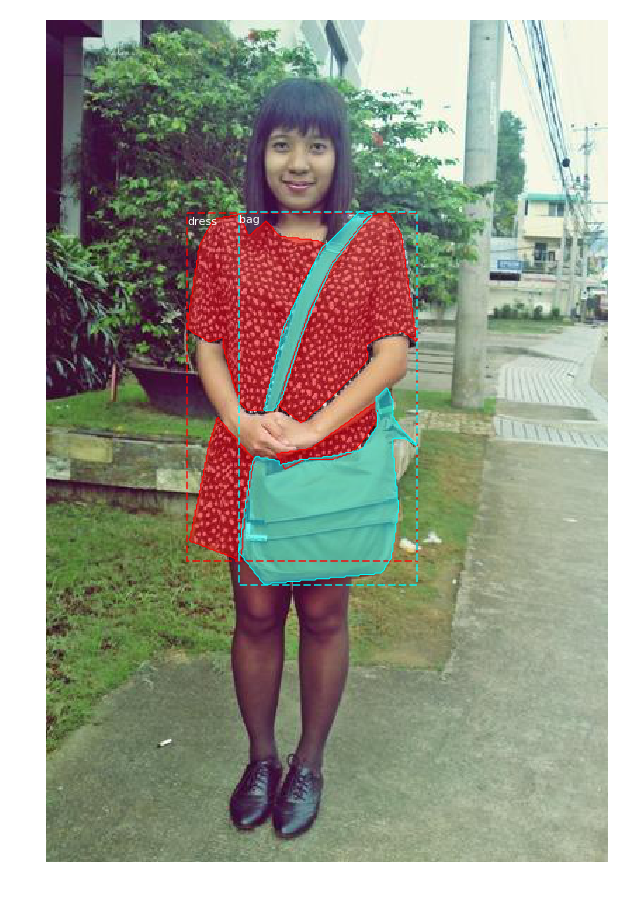

In [21]:
rand_imgid = random.sample(trainids, k=1)[0]
imginfo = [img for img in train_annotations['images'] if img['id']==rand_imgid][0]
annotations = [ann for ann in train_annotations['annotations'] if int(ann['image_id'])==rand_imgid]
img = np.array(Image.open(os.path.join('/data/modanet/images/train', imginfo['file_name'])))
viz_coco_example(img, imginfo, annotations, classnames)